In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# ===== THAM SỐ CẤU HÌNH =====
INPUT_LEN = 14      # Số ngày input
OUTPUT_LEN = 3      # Số ngày output mỗi lần dự đoán
TOTAL_PREDICT_DAYS = 100  # Tổng số ngày cần dự đoán

In [3]:
# Load data train
df_train = pd.read_csv('/kaggle/input/aio-2025-linear-forecasting-challenge/FPT_train.csv')
df_train['time'] = pd.to_datetime(df_train['time'])
df_train = df_train.sort_values('time').reset_index(drop=True)

# Tạo log transform
df_train['close_log'] = np.log(df_train['close'])

print(f"Train data shape: {df_train.shape}")
print(f"Date range: {df_train['time'].min()} to {df_train['time'].max()}")

print(df_train[['time', 'close', 'close_log']].head())


Train data shape: (1149, 8)
Date range: 2020-08-03 00:00:00 to 2025-03-10 00:00:00
        time  close  close_log
0 2020-08-03  19.63   2.977059
1 2020-08-04  19.91   2.991222
2 2020-08-05  20.10   3.000720
3 2020-08-06  20.01   2.996232
4 2020-08-07  20.14   3.002708


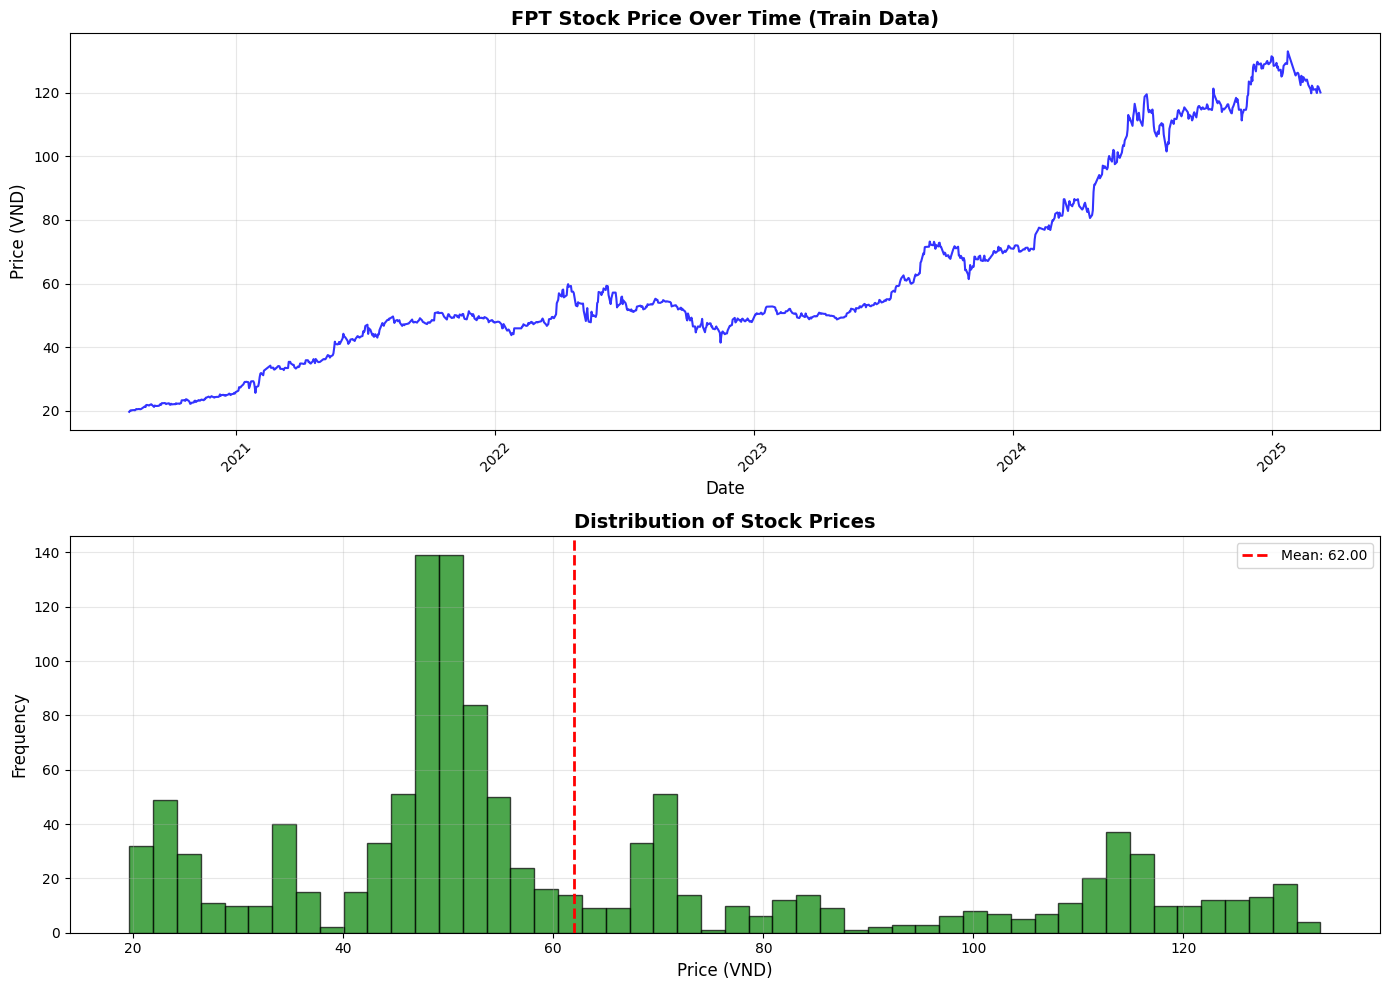

In [4]:
# ===== PHÂN TÍCH DỮ LIỆU =====
# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Giá close theo thời gian
axes[0].plot(df_train['time'], df_train['close'], linewidth=1.5, color='blue', alpha=0.8)
axes[0].set_title('FPT Stock Price Over Time (Train Data)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Price (VND)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Phân phối giá
axes[1].hist(df_train['close'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of Stock Prices', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Price (VND)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].axvline(df_train['close'].mean(), color='red', linestyle='--', 
                 linewidth=2, label=f'Mean: {df_train["close"].mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()


In [5]:
# Linear Model
class LinearModel(nn.Module):
    def __init__(self, input_len, output_len):
        super(LinearModel, self).__init__()
        self.input_len = input_len
        self.output_len = output_len
        self.linear = nn.Linear(input_len, output_len)
    
    def forward(self, x):
        # x: [batch_size, input_len]
        # output: [batch_size, output_len]
        return self.linear(x)

model = LinearModel(INPUT_LEN, OUTPUT_LEN)


In [6]:
# Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_len, output_len, target_col='close_log'):
        self.data = data[target_col].values
        self.input_len = input_len
        self.output_len = output_len
    
    def __len__(self):
        return len(self.data) - self.input_len - self.output_len + 1
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.input_len]
        y = self.data[idx+self.input_len:idx+self.input_len+self.output_len]
        return torch.FloatTensor(x), torch.FloatTensor(y)

# Tạo dataset và dataloader
dataset = TimeSeriesDataset(df_train, INPUT_LEN, OUTPUT_LEN)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Dataset size: {len(dataset)} samples")
print(f"Sample shape: input={INPUT_LEN}, output={OUTPUT_LEN}")



Dataset size: 1133 samples
Sample shape: input=14, output=3


In [7]:
# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

print("Training completed!")



Epoch [5/30], Loss: 0.109830
Epoch [10/30], Loss: 0.001618
Epoch [15/30], Loss: 0.001634
Epoch [20/30], Loss: 0.001599
Epoch [25/30], Loss: 0.001612
Epoch [30/30], Loss: 0.001612
Training completed!


In [8]:
# Gán input inference ban đầu (14 ngày cuối từ train data)
initial_input = df_train['close_log'].values[-INPUT_LEN:].copy()
current_input = initial_input.copy()

# Dự đoán iterative: 14 -> 3 -> 3 -> ... cho đến 100 ngày
model.eval()
all_predictions_log = []

# Bắt đầu với input ban đầu
current_input = initial_input.copy()

with torch.no_grad():
    remaining_days = TOTAL_PREDICT_DAYS
    
    while remaining_days > 0:
        # Số ngày cần dự đoán trong lần này
        predict_this_step = min(OUTPUT_LEN, remaining_days)
        
        # Dự đoán
        input_tensor = torch.FloatTensor(current_input).unsqueeze(0).to(device)
        output = model(input_tensor)
        predictions = output[0].cpu().numpy()[:predict_this_step]
        
        # Lưu predictions
        all_predictions_log.extend(predictions)
        
        # Cập nhật input cho lần tiếp theo: bỏ INPUT_LEN - OUTPUT_LEN ngày đầu, thêm predictions
        current_input = np.concatenate([
            current_input[OUTPUT_LEN:],  # Bỏ OUTPUT_LEN ngày đầu
            predictions  # Thêm predictions mới
        ])
        
        remaining_days -= predict_this_step


In [9]:
# Chuyển đổi từ log về giá close
predictions_close = np.exp(all_predictions_log)

# Id: 100 số nguyên liên tiếp từ 1 đến 100
prediction_ids = list(range(1, TOTAL_PREDICT_DAYS + 1))


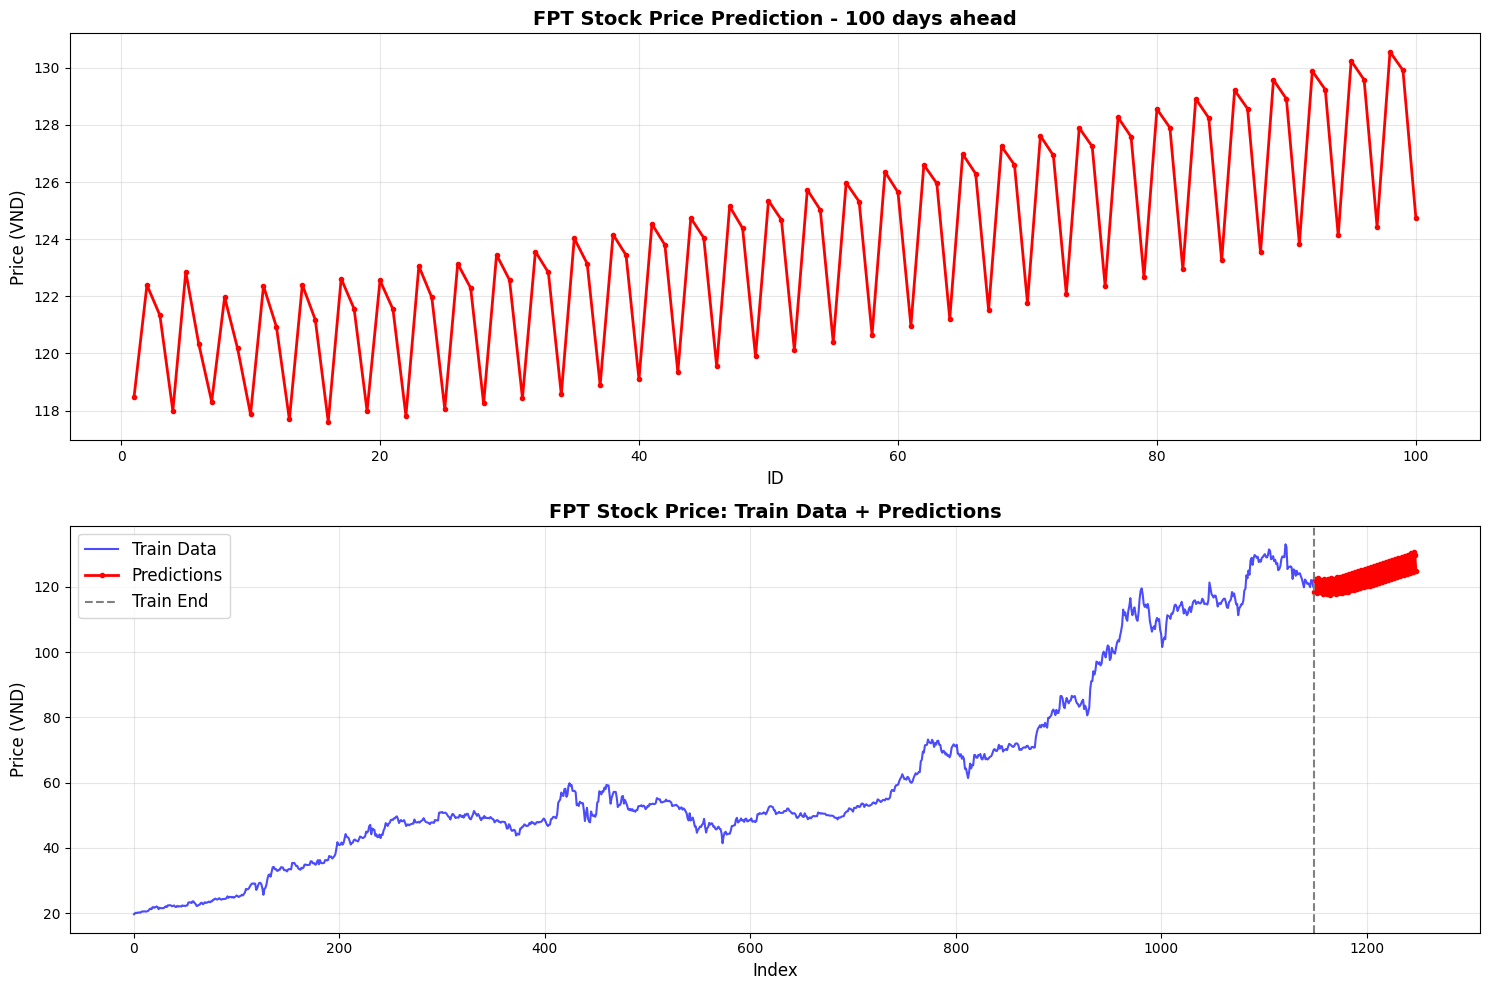

In [10]:
# Visualization kết quả dự đoán
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Dự đoán 100 ngày tiếp theo
axes[0].plot(prediction_ids, predictions_close, linewidth=2, color='red', marker='o', markersize=3)
axes[0].set_title(f'FPT Stock Price Prediction - {TOTAL_PREDICT_DAYS} days ahead', fontsize=14, fontweight='bold')
axes[0].set_xlabel('ID', fontsize=12)
axes[0].set_ylabel('Price (VND)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: Kết hợp train data và predictions
last_train_idx = len(df_train)
axes[1].plot(range(len(df_train)), df_train['close'], linewidth=1.5, color='blue', alpha=0.7, label='Train Data')
axes[1].plot(range(last_train_idx, last_train_idx + TOTAL_PREDICT_DAYS), predictions_close, linewidth=2, color='red', marker='o', markersize=3, label='Predictions')
axes[1].axvline(last_train_idx, color='gray', linestyle='--', linewidth=1.5, label='Train End')
axes[1].set_title('FPT Stock Price: Train Data + Predictions', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Index', fontsize=12)
axes[1].set_ylabel('Price (VND)', fontsize=12)
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
# Tạo file CSV output với format: id, close
output_df = pd.DataFrame({
    'id': prediction_ids,
    'close': predictions_close
})

# Lưu file CSV
output_filename = 'submission.csv'
output_df.to_csv(output_filename, index=False)
print(f"Đã lưu file: {output_filename}")

Đã lưu file: submission.csv
